In [14]:
# open .gz file and read rdf triples into a graph
# then use the graph to query the data
#

import gzip
import rdflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import time
import datetime
import math
import random
import pickle
from collections import defaultdict
from collections import Counter
from collections import OrderedDict

from rdflib import URIRef, BNode, Literal
from rdflib import Namespace
from rdflib.namespace import RDF, RDFS, FOAF
from rdflib import Graph, Dataset, ConjunctiveGraph
from rdflib import ConjunctiveGraph

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler

In [1]:
from rdflib.namespace import Namespace, RDF, RDFS, XSD
from rdflib.term import URIRef, Literal
import csv
import json
import networkx as nx
import pandas as pd
import rdflib
from collections import defaultdict, Counter
import locale

In [2]:
import dask.dataframe as dd

In [3]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# df = pd.read_parquet(
#         'embeddings-generation/embeddings.parquet', 
#         engine="pyarrow",
#         columns=None,)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.sql.functions import col, expr
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('embeddings_viz').config('spark.driver.memory', '800g').config('spark.executor.memory', '800g').config('spark.driver.maxResultSize', '800g').getOrCreate()
# Load the data
# df = spark.read.parquet('embeddings-generation/pca_features.parquet')
df = spark.read.parquet('embeddings-generation/embeddings.parquet')

print("Number of rows: ", df.count())
print("Number of columns: ", len(df.columns))
df.show(1, truncate=False)
print("DATASET LOAD DONE")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/27 13:16:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of rows:  502634946
Number of columns:  2


+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## PCA Visualizations

In [ ]:
# load the data to pandas
df_pandas = df.toPandas()
print("Number of rows: ", df_pandas.shape[0])
print("Number of columns: ", df_pandas.shape[1])
df_pandas.head(1)
print("DATASET LOAD DONE")

In [8]:
df_pandas.head(1)

,pcaFeatures
0,"[0.5865946466572356, 0.21728537579609356]"


DATASET SPLIT DONE


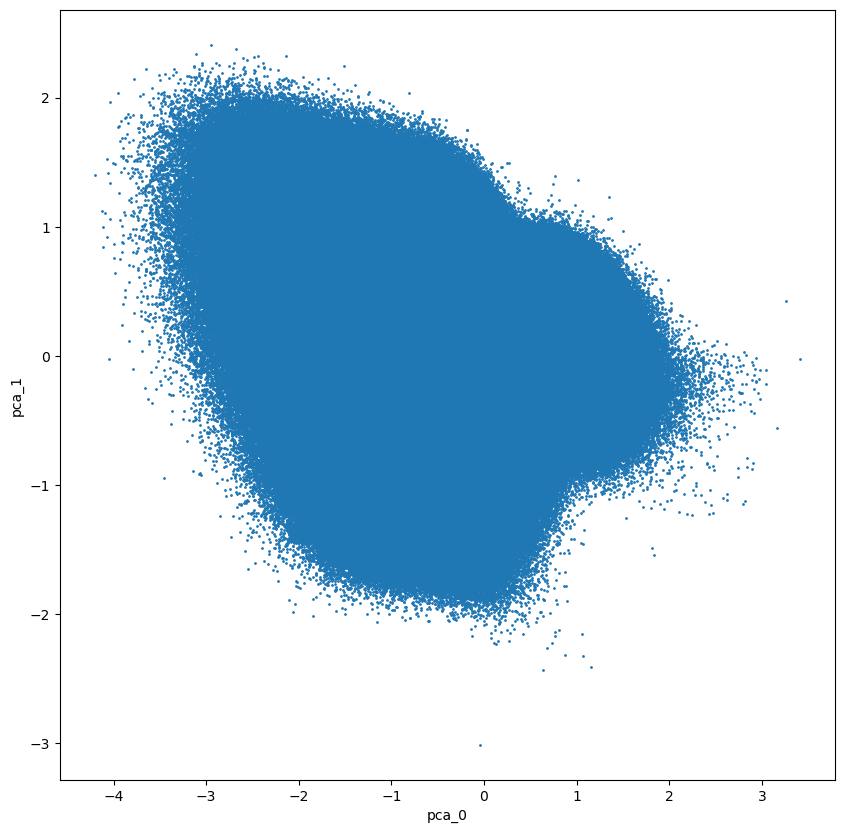

VISUALIZATION DONE
VISUALIZATION SAVED


<Figure size 640x480 with 0 Axes>

In [9]:
# dataset contains in each row a vector of 2 dimensions where dimension 0 is pca_0 and dimension 1 is pca_1
# we need to split the vector into 2 columns
df_pandas['pca_0'] = df_pandas['pcaFeatures'].apply(lambda x: x[0])
df_pandas['pca_1'] = df_pandas['pcaFeatures'].apply(lambda x: x[1])
print("DATASET SPLIT DONE")

# visualize the data
plt.figure(figsize=(10, 10))
plt.scatter(df_pandas['pca_0'], df_pandas['pca_1'], s=1)
plt.xlabel('pca_0')
plt.ylabel('pca_1')
plt.show()
print("VISUALIZATION DONE")

# save the plot
plt.savefig('embeddings-generation/pca_features.png')
print("VISUALIZATION SAVED")

# UMAP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.sql.functions import col, expr
from pyspark.sql import SparkSession

# load first 1000 rows of the data 'embeddings-generation/embeddings.parquet' in pyarrow 
spark = SparkSession.builder.appName('embeddings_viz').config('spark.driver.memory', '800g').config('spark.executor.memory', '800g').config('spark.driver.maxResultSize', '800g').getOrCreate()
# Load the data
df = spark.read.parquet('embeddings-generation/embeddings.parquet')

# first 1000 rows
df_small = df.limit(10)
print("Number of rows: ", df_small.count())
print("Number of columns: ", len(df_small.columns))
df_small.show(1, truncate=False)

# Convert array<float> to linalg.Vector
df_vectorized = df.withColumn("embedding", array_to_vector(col("embedding")))

# drop id column
df_vectorized = df_vectorized.drop('id')

# print first row
df_vectorized.show(1, truncate=False)
print("VECTORIZE DONE")

# convert to pandas
df_pandas = df_vectorized.toPandas()
print("Number of rows: ", df_pandas.shape[0])
print("Number of columns: ", df_pandas.shape[1])
df_pandas.head(1)
print("DATASET LOAD DONE")

# run UMAP on the data
import umap
reducer = umap.UMAP(input='array', n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(df_pandas)
print("UMAP DONE")

# save the embedding
np.save('embeddings-generation/umap_embedding.npy', embedding)
print("EMBEDDING SAVED")

# visualize the data
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
plt.show()
print("VISUALIZATION DONE")

# save the plot
plt.savefig('embeddings-generation/umap_embeddings.png')
print("VISUALIZATION SAVED")


ConnectionRefusedError: [Errno 111] Connection refused

# KG

In [5]:
# prefixes used in the graph
WD = Namespace('http://www.wikidata.org/entity/')
WDT = Namespace('http://www.wikidata.org/prop/direct/')
SCHEMA = Namespace('http://schema.org/')

In [6]:
entities = set(g.subjects()) | {s for s in g.objects() if isinstance(s, URIRef)}
predicates = set(g.predicates())
literals = {s for s in g.objects() if isinstance(s, Literal)}
with_type = set(g.subjects(WDT['P31'], None))
with_super = set(g.subjects(WDT['P279'], None))
types = set(g.objects(None, WDT['P31']))
supers = set(g.objects(None, WDT['P279']))
with_label = set(g.subjects(RDFS.label, None))
n_ents = len(entities)
n_rels = len(predicates)
n_lits = len(literals)
t_tot = len(g)
t_ent = len([1 for s,p,o in g.triples((None, None, None)) if isinstance(o, URIRef)])
t_lit = t_tot - t_ent
n_notype = len(entities - with_type - with_super)
n_notype_flt = len(entities - with_type - with_super - types - supers)
pd.DataFrame([
('number of entities', f'{n_ents:n}'),
('number of literals', f'{n_lits:n}'),
('number of predicates', f'{n_rels:n}'),
('number of triples', f'{t_tot:n}'),
('number of ent-ent triples', f'{t_ent:n}'),
('number of ent-lit triples', f'{t_lit:n}'),
('number of entities w/o label', f'{len(entities - with_label):n}'),
('number of predicates w/o label', f'{len(predicates - with_label):n}'),
('number of entities w/o type', f'{n_notype:n}'),
('number of instances w/o type', f'{n_notype_flt:n}'),
])

,0,1
0,number of entities,0
1,number of literals,0
2,number of predicates,0
3,number of triples,6333494
4,number of ent-ent triples,0
5,number of ent-lit triples,6333494
6,number of entities w/o label,0
7,number of predicates w/o label,0
8,number of entities w/o type,0
9,number of instances w/o type,0
